In [141]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder

In [120]:
train = pd.read_feather('train_raw')
test = pd.read_feather('test_raw')
print(train.shape, test.shape)

(8921483, 83) (7853253, 82)


In [124]:
train.head()

,MachineIdentifier,ProductName,EngineVersion,AppVersion,AvSigVersion,IsBeta,RtpStateBitfield,IsSxsPassiveMode,DefaultBrowsersIdentifier,AVProductStatesIdentifier,...,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsWIMBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier,HasDetections
0,0,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1735.0,0,7.0,0,NaN,53447.0,...,36144.0,0,NaN,0.0,0,0,0.0,0.0,10.0,0
1,1,win8defender,1.1.14600.4,4.13.17134.1,1.263.48.0,0,7.0,0,NaN,53447.0,...,57858.0,0,NaN,0.0,0,0,0.0,0.0,8.0,0
2,2,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1341.0,0,7.0,0,NaN,53447.0,...,52682.0,0,NaN,0.0,0,0,0.0,0.0,3.0,0
3,3,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1527.0,0,7.0,0,NaN,53447.0,...,20050.0,0,NaN,0.0,0,0,0.0,0.0,3.0,1
4,4,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1379.0,0,7.0,0,NaN,53447.0,...,19844.0,0,0.0,0.0,0,0,0.0,0.0,1.0,1


In [125]:
#Identify the fill rate of columns
missing_df = pd.DataFrame([{'column':c, 'missing':(train[c].isnull().sum()/train.shape[0])*100} for c in train.columns])
missing_df = missing_df.sort_values('missing',ascending=False)
print(missing_df.shape)
missing_df.head(10)

(83, 2)


,column,missing
28,PuaMode,99.974119
41,Census_ProcessorClass,99.589407
8,DefaultBrowsersIdentifier,95.141637
68,Census_IsFlightingInternal,83.044030
52,Census_InternalBatteryType,71.046809
71,Census_ThresholdOptIn,63.524472
75,Census_IsWIMBootEnabled,63.439038
31,SmartScreen,35.610795
15,OrganizationIdentifier,30.841487
29,SMode,6.027686


In [126]:
skew_df = pd.DataFrame([{'column':c, 'unique_val':train[c].nunique(), 
                         'skewness':train[c].value_counts(normalize=True).values[0]*100} for c in train.columns])
skew_df = skew_df.sort_values('skewness', ascending = False)
print(skew_df.shape)
skew_df.head(10)

(83, 3)


,column,skewness,unique_val
75,Census_IsWIMBootEnabled,99.999969,2
5,IsBeta,99.999249,2
69,Census_IsFlightsDisabled,99.998996,2
68,Census_IsFlightingInternal,99.998612,2
27,AutoSampleOptIn,99.997108,2
71,Census_ThresholdOptIn,99.974924,2
29,SMode,99.953708,2
65,Census_IsPortableOperatingSystem,99.945480,2
28,PuaMode,99.913382,2
35,Census_DeviceFamily,99.838256,3


In [127]:
train.Census_IsWIMBootEnabled.value_counts()

0.0    3261779
1.0          1
Name: Census_IsWIMBootEnabled, dtype: int64

In [128]:
droppable_features = []

In [129]:
droppable_features.extend(missing_df[missing_df.missing > 99].column.tolist())
droppable_features.extend(skew_df[skew_df.skewness >99].column.tolist())
print(droppable_features)

['PuaMode', 'Census_ProcessorClass', 'Census_IsWIMBootEnabled', 'IsBeta', 'Census_IsFlightsDisabled', 'Census_IsFlightingInternal', 'AutoSampleOptIn', 'Census_ThresholdOptIn', 'SMode', 'Census_IsPortableOperatingSystem', 'PuaMode', 'Census_DeviceFamily', 'UacLuaenable', 'Census_IsVirtualDevice']


In [130]:
droppable_features.remove('PuaMode')
print(droppable_features)

['Census_ProcessorClass', 'Census_IsWIMBootEnabled', 'IsBeta', 'Census_IsFlightsDisabled', 'Census_IsFlightingInternal', 'AutoSampleOptIn', 'Census_ThresholdOptIn', 'SMode', 'Census_IsPortableOperatingSystem', 'PuaMode', 'Census_DeviceFamily', 'UacLuaenable', 'Census_IsVirtualDevice']


In [131]:
train.drop(droppable_features, axis=1, inplace=True)

In [132]:
# normalize values in Smartscreen
trans_dict = {'off': 'Off', '&#x02;': '2', '&#x01;': '1', 'on': 'On',
              'requireadmin': 'RequireAdmin', 'OFF': 'Off', 'Promt': 'Prompt', 
              'requireAdmin': 'RequireAdmin', 'prompt': 'Prompt', 'warn': 'Warn', 
              '00000000': '0', '&#x03;': '3'}#, np.nan: 'NoExist'
train.replace({'SmartScreen': trans_dict}, inplace=True)

In [133]:
# normalize values Census_InternalBatteryType
trans_dict = { '˙˙˙': 'unknown', 'unkn': 'unknown', np.nan: 'unknown'}
train.replace({'Census_InternalBatteryType': trans_dict}, inplace=True)

In [134]:
train.shape

(8921483, 70)

# Label Encoding

In [135]:
train['SmartScreen'] = train.SmartScreen.astype('category')
train['Census_InternalBatteryType'] = train.Census_InternalBatteryType.astype('category')

cat_cols = train.select_dtypes(include='category').columns.tolist()
print(cat_cols)

['ProductName', 'EngineVersion', 'AppVersion', 'AvSigVersion', 'Platform', 'Processor', 'OsVer', 'OsPlatformSubRelease', 'OsBuildLab', 'SkuEdition', 'SmartScreen', 'Census_MDC2FormFactor', 'Census_PrimaryDiskTypeName', 'Census_ChassisTypeName', 'Census_PowerPlatformRoleName', 'Census_InternalBatteryType', 'Census_OSVersion', 'Census_OSArchitecture', 'Census_OSBranch', 'Census_OSEdition', 'Census_OSSkuName', 'Census_OSInstallTypeName', 'Census_OSWUAutoUpdateOptionsName', 'Census_GenuineStateName', 'Census_ActivationChannel', 'Census_FlightRing']


In [136]:
le = LabelEncoder()

for col in cat_cols:
    train[col] = train[col].astype('str')
    train[col] = le.fit_transform(train[col])

# Feature co-rellation

In [137]:
cols = train.columns.tolist()

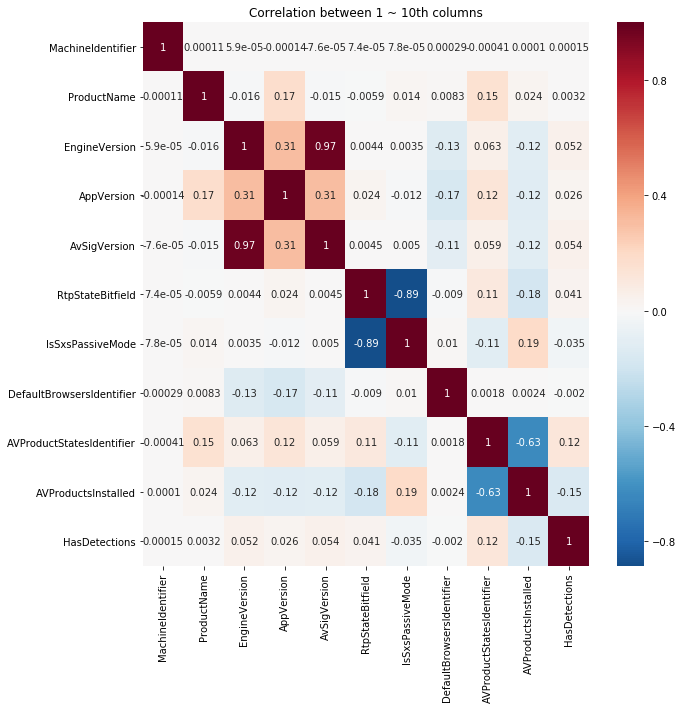

In [142]:
plt.figure(figsize=(10,10))
co_cols = cols[:10]
co_cols.append('HasDetections')
sns.heatmap(train[co_cols].corr(), cmap='RdBu_r', annot=True, center=0.0)
plt.title('Correlation between 1 ~ 10th columns')
plt.show()

In [143]:
corr_remove = []

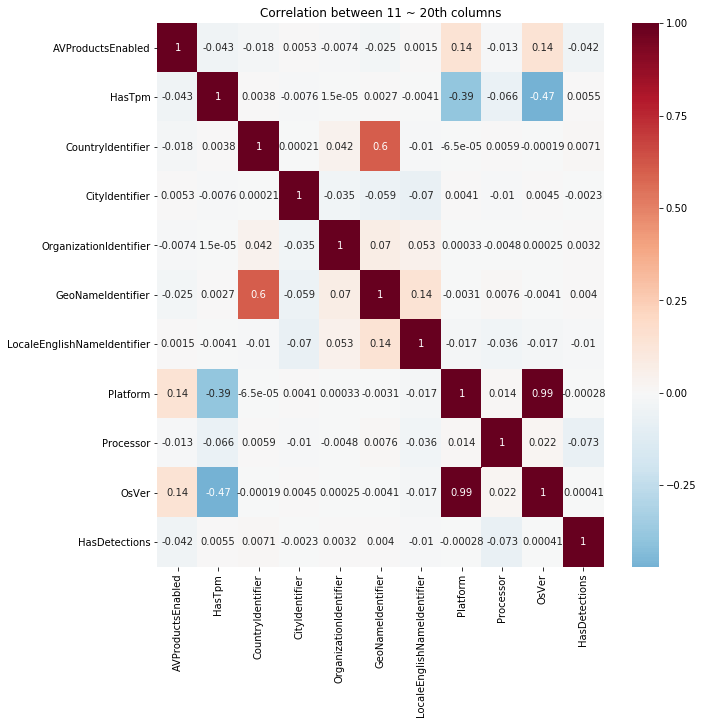

In [144]:
co_cols = cols[10:20]
co_cols.append('HasDetections')
plt.figure(figsize=(10,10))
sns.heatmap(train[co_cols].corr(), cmap='RdBu_r', annot=True, center=0.0)
plt.title('Correlation between 11 ~ 20th columns')
plt.show()

In [145]:
print(train.Platform.nunique())
print(train.OsVer.nunique())

4
58


In [146]:
corr_remove.append('Platform')

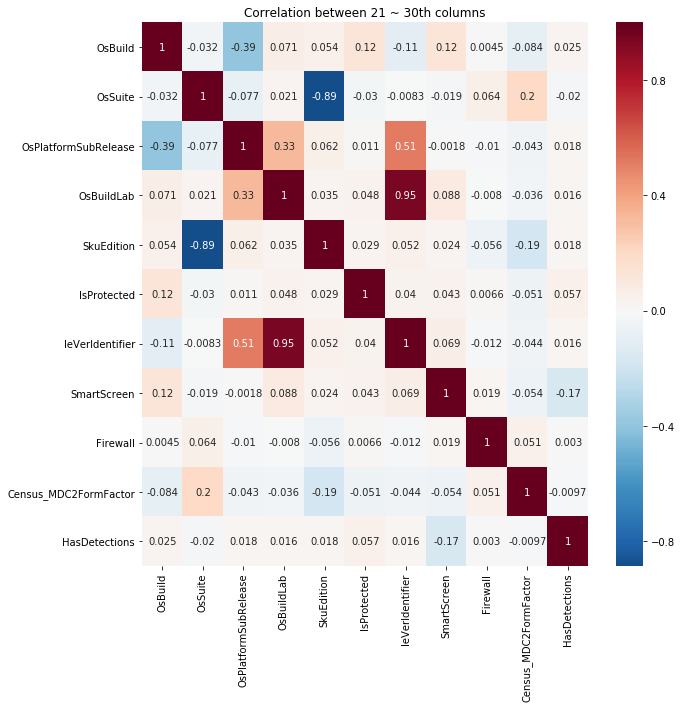

In [147]:
co_cols = cols[20:30]
co_cols.append('HasDetections')
plt.figure(figsize=(10,10))
sns.heatmap(train[co_cols].corr(), cmap='RdBu_r', annot=True, center=0.0)
plt.title('Correlation between 21 ~ 30th columns')
plt.show()

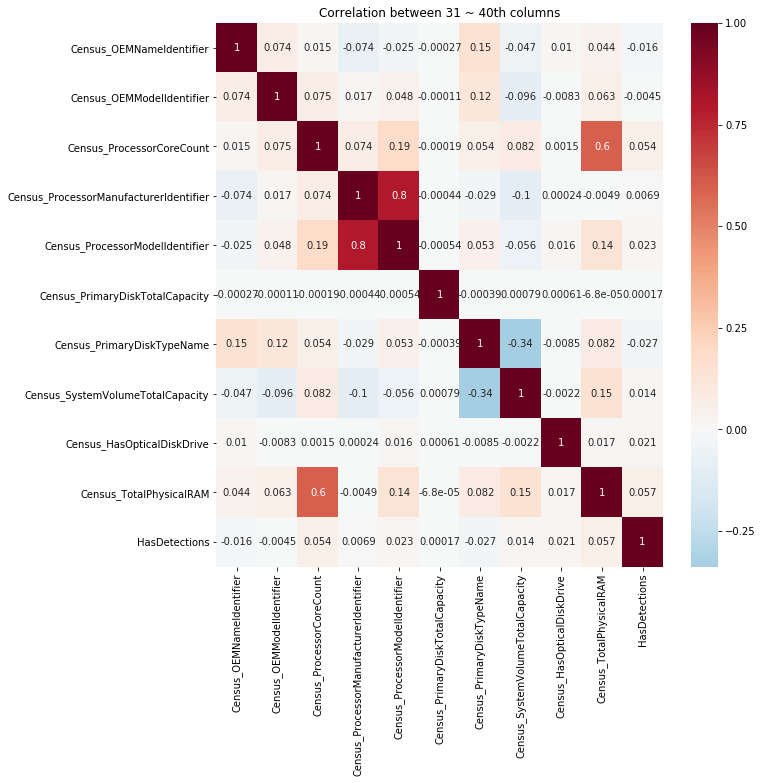

In [148]:
co_cols = cols[30:40]
co_cols.append('HasDetections')
plt.figure(figsize=(10,10))
sns.heatmap(train[co_cols].corr(), cmap='RdBu_r', annot=True, center=0.0)
plt.title('Correlation between 31 ~ 40th columns')
plt.show()

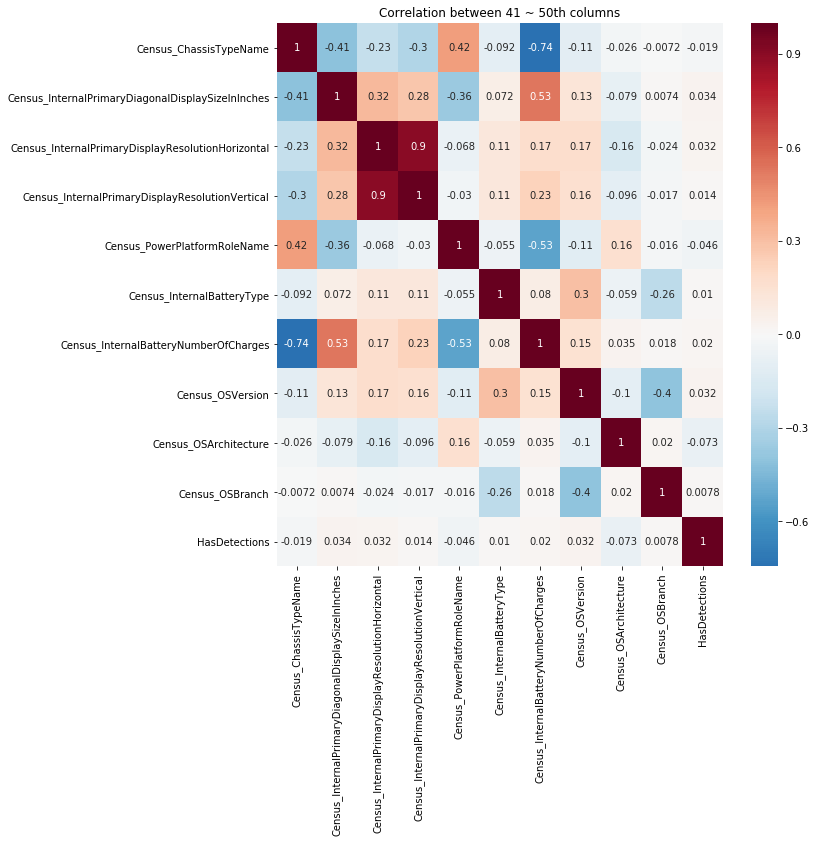

In [149]:
co_cols = cols[40:50]
co_cols.append('HasDetections')
plt.figure(figsize=(10,10))
sns.heatmap(train[co_cols].corr(), cmap='RdBu_r', annot=True, center=0.0)
plt.title('Correlation between 41 ~ 50th columns')
plt.show()

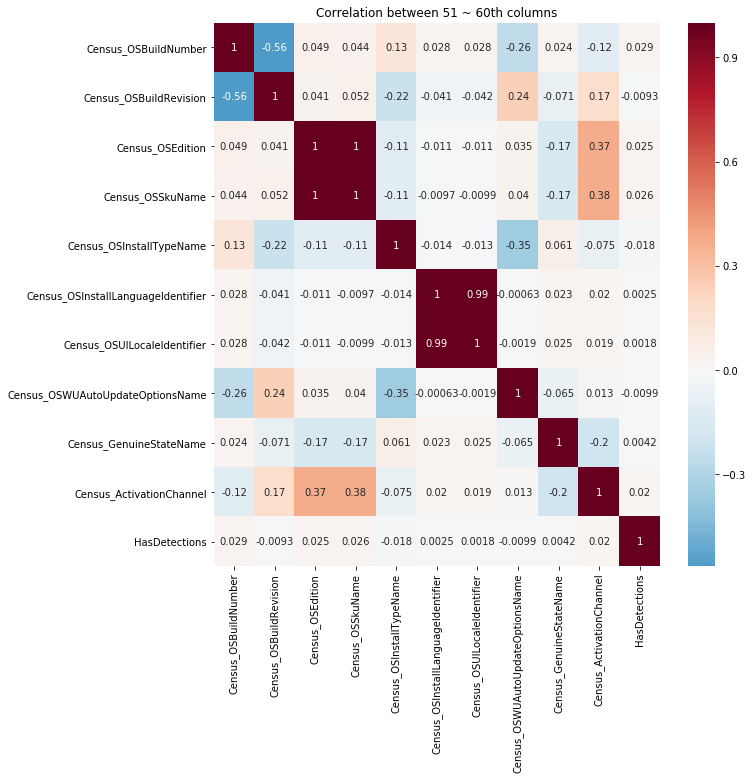

In [150]:
co_cols = cols[50:60]
co_cols.append('HasDetections')
plt.figure(figsize=(10,10))
sns.heatmap(train[co_cols].corr(), cmap='RdBu_r', annot=True, center=0)
plt.title('Correlation between 51 ~ 60th columns')
plt.show()

In [151]:
print(train.Census_OSEdition.nunique())
print(train.Census_OSSkuName.nunique(), '\n')
print(train.Census_OSInstallLanguageIdentifier.nunique())
print(train.Census_OSUILocaleIdentifier.nunique())

33
30 

39
147


In [152]:
corr_remove.append('Census_OSSkuName')
corr_remove.append('Census_OSInstallLanguageIdentifier')

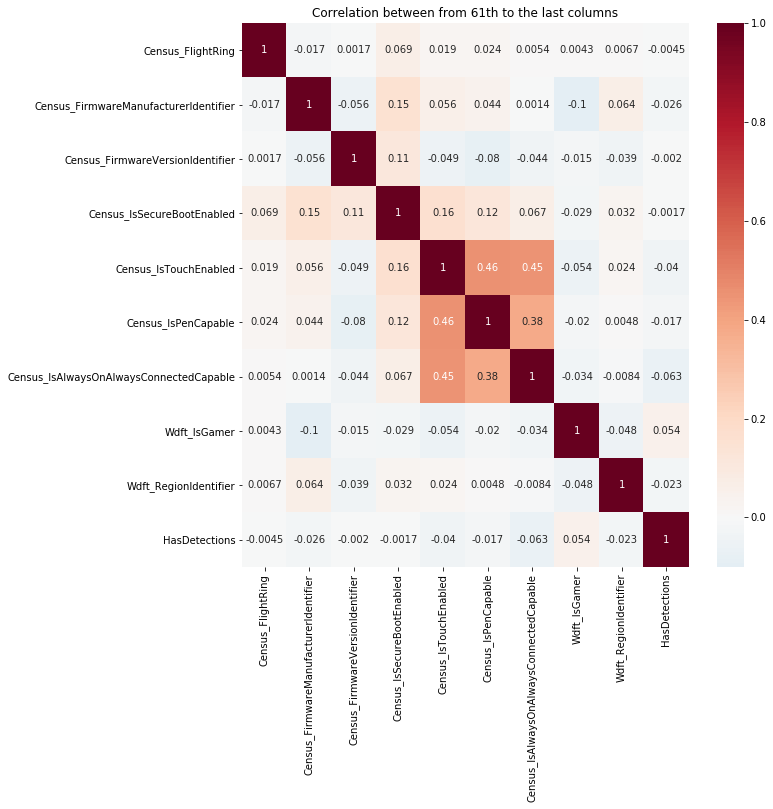

In [153]:
co_cols = cols[60:]
#co_cols.append('HasDetections')
plt.figure(figsize=(10,10))
sns.heatmap(train[co_cols].corr(), cmap='RdBu_r', annot=True, center=0)
plt.title('Correlation between from 61th to the last columns')
plt.show()

In [154]:
corr_remove

['Platform', 'Census_OSSkuName', 'Census_OSInstallLanguageIdentifier']

In [155]:
train.drop(corr_remove, axis=1, inplace=True)

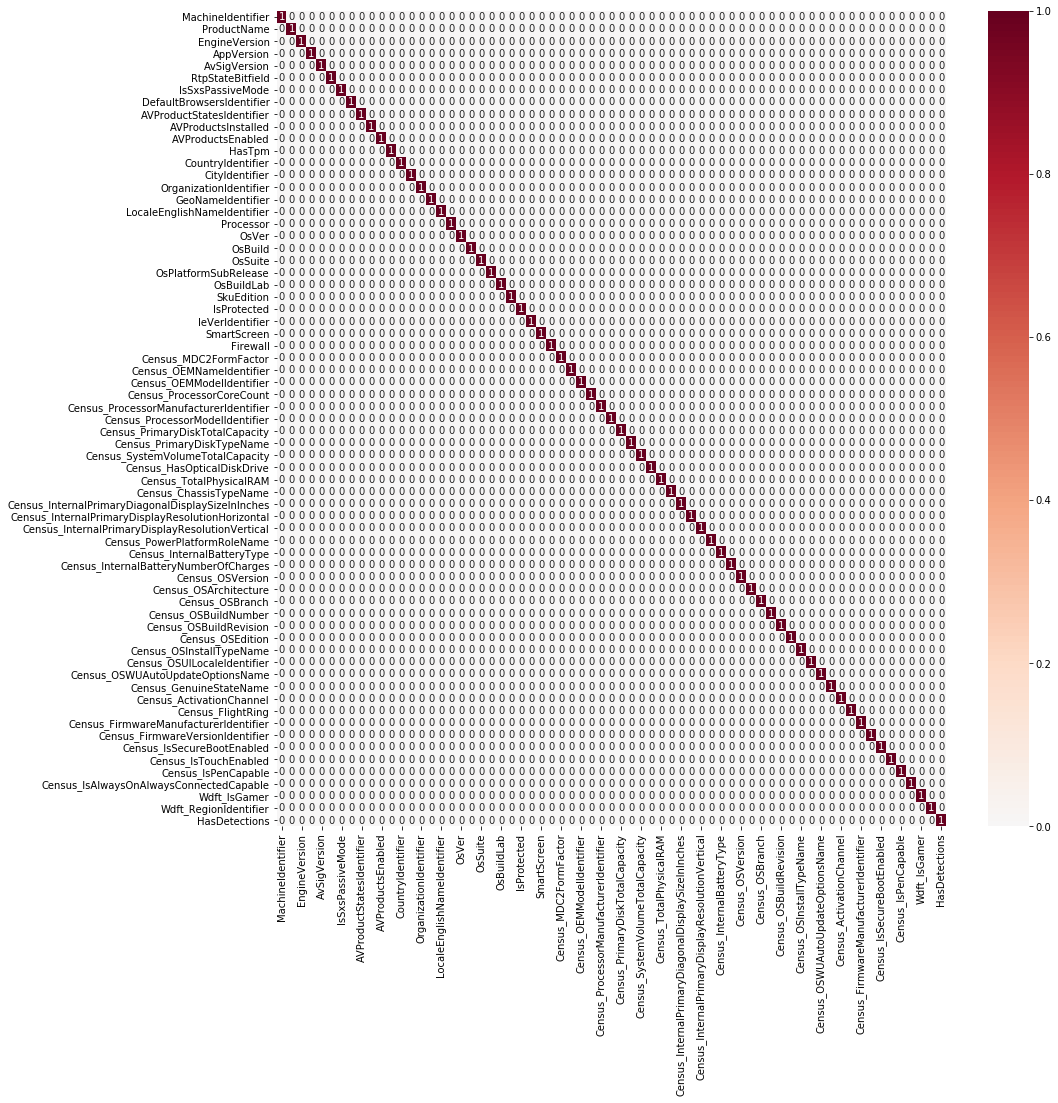

In [156]:
corr = train.corr()
high_corr = (corr >= 0.99).astype('uint8')
plt.figure(figsize=(15,15))
sns.heatmap(high_corr, cmap='RdBu_r', annot=True, center=0.0)
plt.show()

In [157]:
print(train.Census_OSArchitecture.nunique())
print(train.Processor.nunique())

3
3


In [158]:
train[['Census_OSArchitecture', 'Processor', 'HasDetections']].corr()

,Census_OSArchitecture,Processor,HasDetections
Census_OSArchitecture,1.000000,0.988892,-0.072757
Processor,0.988892,1.000000,-0.073186
HasDetections,-0.072757,-0.073186,1.000000


In [159]:
corr_remove.append('Processor')

In [160]:
droppable_features.extend(corr_remove)
print(len(droppable_features))
droppable_features

17


['Census_ProcessorClass',
 'Census_IsWIMBootEnabled',
 'IsBeta',
 'Census_IsFlightsDisabled',
 'Census_IsFlightingInternal',
 'AutoSampleOptIn',
 'Census_ThresholdOptIn',
 'SMode',
 'Census_IsPortableOperatingSystem',
 'PuaMode',
 'Census_DeviceFamily',
 'UacLuaenable',
 'Census_IsVirtualDevice',
 'Platform',
 'Census_OSSkuName',
 'Census_OSInstallLanguageIdentifier',
 'Processor']